In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [388]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][1]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [287]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [389]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][1] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



import place_field_analysis as pf
reload(pf)

cell_cols = cell_cols_d['pyr']
fr_map_d,count_d,occu_d,bins_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1.,nbins=100,smth_in_bin=2.5)
spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],100,retbins=True,labels=False)


# get fields
fr_map_peaks_d = {}
field_res_d = {}
min_rate=0.6
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_rate=min_rate)
    
# turn tensor into df!!!
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols_d['pyr'],trialtype_key='visitedArm',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial =  {}
for tt in [0,1]:
    tensor=fr_map_dict[tt][0]
    posbin_l = np.arange(tensor.shape[1])
    index=pd.MultiIndex.from_product([cell_cols_d['pyr'],posbin_l])
    fr_map_trial_onetrialtype = pd.DataFrame(tensor.reshape(-1,tensor.shape[-1]),index=index)
    fr_map_trial[tt] = fr_map_trial_onetrialtype

reload(pf)
field_params_trial=pf.get_field_params_trial(fr_map_trial[0],field_res_d[(0,0)]['all_fields'])
X =field_params_trial.loc['fr']

load *SessionPulses.Events.mat failed
<module 'sys' (built-in)>


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:39: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_entropy.py:77: Runtime

cant format into a dataframe
cant format into a dataframe


In [400]:
X =field_params_trial.loc['fr']

In [36]:
# reload(cpa)
# %time best_ncpts_l = cpa.cv_all_signals(X,ncpts_l=[0,1,2,3,4])

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


CPU times: user 912 ms, sys: 694 ms, total: 1.61 s
Wall time: 1min 41s


In [107]:
# signal = X.iloc[0].values
# %time best_ncpts,err_l_d = cpa.cv_one_signal(signal,ncpts_l = [0,1,2,3,4],cost='l2')

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.21 s


In [264]:
fr_map_peaks_tested_df=field_res_d[(0,0)]['fr_map_peaks_tested_df']

In [30]:
# import nmf_test as nt
# reload(nt)
# %time instability_pval = nt.test_contiguity_allrows(X,n_shuffle=200,sig_thresh=0.05,n_change_pts=1)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 101 ms, sys: 629 ms, total: 730 ms
Wall time: 25.5 s


In [31]:
# %time instability_pval_2 = nt.test_contiguity_allrows(X,n_shuffle=200,sig_thresh=0.05,n_change_pts=2)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 120 ms, sys: 626 ms, total: 746 ms
Wall time: 3min 14s


In [32]:
# unstable_from_shuffle=instability_pval <= 0.05
# unstable_from_shuffle_2 = instability_pval_2 <= 0.05

In [33]:
unstable_from_shuffle.sum()

178

In [34]:
unstable_from_shuffle_2.sum()

179

In [258]:
selected_all=best_ncpts_l.index[(best_ncpts_l==2)&(~unstable_from_shuffle_2)]

In [160]:
unstable_from_cv = best_ncpts_l > 0

In [201]:
selected_all = unstable_from_shuffle.index[(~unstable_from_shuffle) & (unstable_from_cv)]

In [227]:
best_ncpts_l.loc[48]

0    1
1    2
2    2
dtype: int64

In [268]:
# nt.test_contiguity(X.loc[115,0].values,n_shuffle=200,n_change_pts=2)

100%|██████████| 200/200 [00:02<00:00, 83.74it/s]


(99.00107081280139,
 array([117.76860201, 129.65732139, 137.06780024, 118.28817232,
        113.98205325, 115.48919331, 129.81683979, 120.87841986,
        132.11374689, 134.35417998, 128.25902661, 111.74020878,
        115.25916265, 135.42320196, 122.70675953, 120.93855709,
        130.97443435, 130.73470364, 133.77978975, 141.74035979,
        125.00411271, 142.05770746, 130.22561567, 126.30631172,
        125.90333644, 123.23314931, 110.17935675, 120.44194594,
        129.78107721, 112.82931878, 116.3535542 , 124.64762845,
        126.72207181, 132.12090137, 119.25976048, 129.09145391,
        135.80710524, 127.31671002, 125.24543642, 126.51060005,
        120.30736801, 145.61216044, 124.33983509, 129.54810185,
        129.3353197 , 108.71523635, 135.82859241, 118.84238183,
        129.99814231, 130.58399121, 111.29613754, 116.71147244,
        138.84898586, 108.74720669, 130.30315764, 135.20770417,
        128.81540275, 126.42445808, 115.34510247, 137.5870031 ,
        126.1769606 

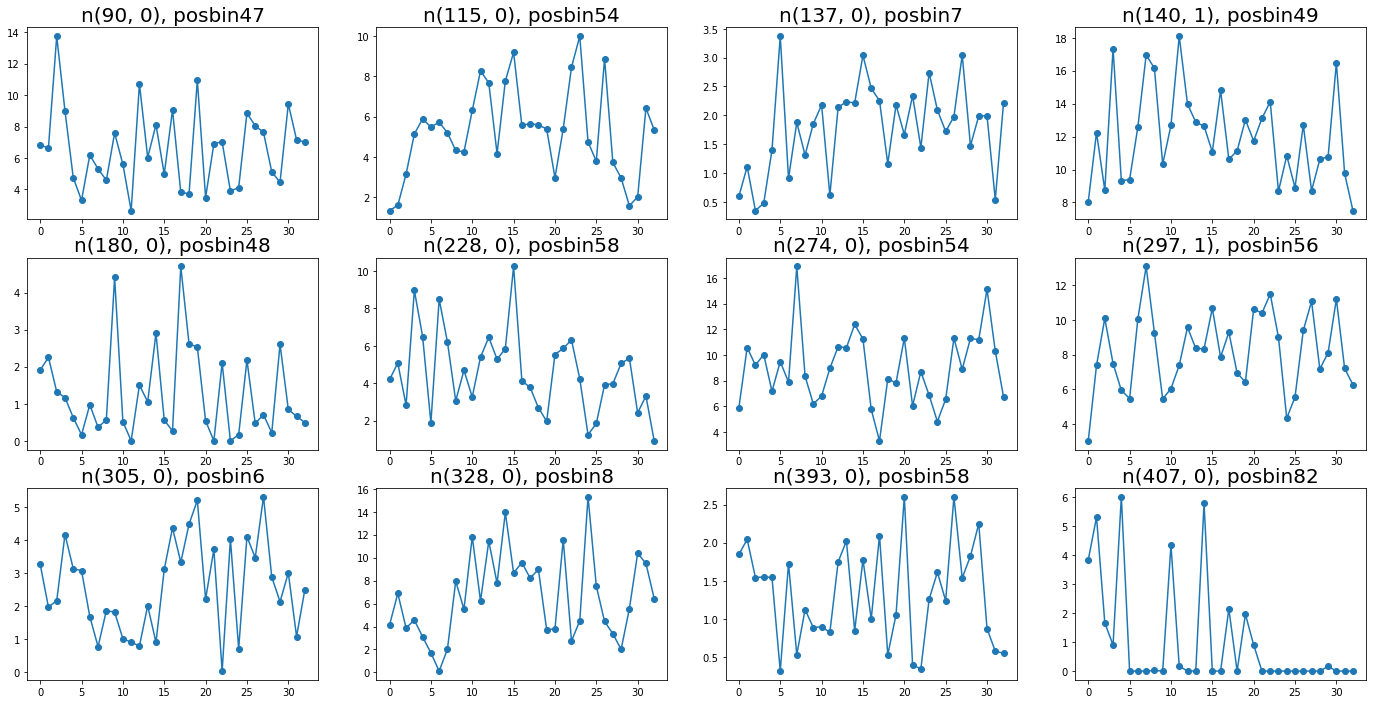

In [262]:
# # selected_all = best_ncpts_l.loc[best_ncpts_l==1].index
# nplots = 12
# st=0
# fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
# for ii,jj in enumerate(range(st*nplots,(st+1)*nplots)):
#     ax = axs.ravel()[ii]
#     ind = selected_all[jj]
#     field = fr_map_peaks_tested_df.loc[ind[0],ind[1]]
#     X.loc[ind].plot(ax=ax,marker='o')
#     ax.set_title(f'n{ind}, posbin{int(field)}')

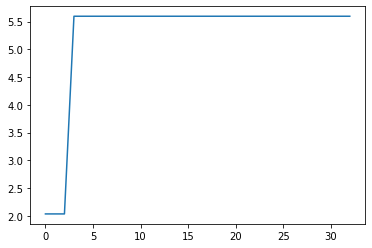

In [264]:
reload(cpa)
signal = X.loc[115,0].values
signal_pred,cpts=cpa.predict_from_cpts_wrapper(signal,1)

plt.plot(signal_pred)

<AxesSubplot:>

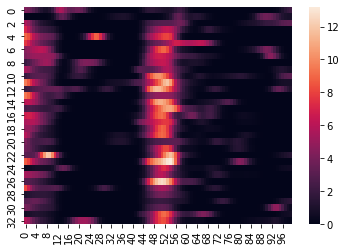

In [266]:
sns.heatmap(fr_map_trial[0].loc[115].T)

In [140]:
best_ncpts,err_l_d = cpa.cv_one_signal(signal,ncpts_l = [0,1,2,3,4],cost='l2')
err_l_d

,0,1,2,3,4
0,0.344268,11.777354,11.777354,11.777354,11.777354
1,18.310335,2.056317,2.056317,2.056317,2.056317
2,8.484808,0.004597,0.004597,0.004597,0.004597
3,12.874858,0.552174,0.552174,0.552174,0.552174
4,16.257163,1.408841,1.408841,1.408841,1.408841
5,0.246977,7.756404,7.756404,7.756404,7.756404
6,2.000905,0.821715,0.384320,0.384320,0.384320
7,8.431809,5.739423,0.755663,1.448495,0.755663
8,18.156339,14.084837,16.464902,13.374716,16.166125
9,0.000199,0.243996,4.081934,4.081934,4.081934


In [147]:
import nmf_test as nt
nt.test_contiguity(signal,n_shuffle=200,sig_thresh=0.05,n_change_pts=1)

100%|██████████| 200/200 [00:00<00:00, 649.14it/s]


(191.55956300923012,
 array([213.39862834, 226.0444841 , 233.3245791 , 213.37787182,
        205.56940152, 203.72341088, 204.67116598, 202.49370639,
        209.77353092, 224.56646026, 195.82583914, 212.8941953 ,
        210.35589254, 195.23716906, 220.11201723, 210.11999214,
        229.3006118 , 213.1971107 , 222.96318987, 225.73672827,
        193.53440952, 212.97391862, 206.51272199, 220.07135059,
        217.06095916, 208.63224104, 188.34797352, 224.93391667,
        208.23291992, 196.63008857, 213.55963465, 204.31238522,
        164.33564895, 188.3307123 , 209.35731242, 217.45790311,
        225.54150476, 176.32605161, 223.96869727, 210.97069064,
        202.49370639, 183.62262778, 231.15470818, 218.45302711,
        218.03499868, 215.52178899, 211.51161252, 181.38874418,
        210.37288441, 232.37861561, 208.70253607, 204.62598481,
        230.3828736 , 219.73591414, 202.39313213, 211.51161252,
        212.04809251, 184.58382643, 204.20851555, 182.23351427,
        200.9304455

In [38]:
X_norm = scipy.stats.zscore(X,axis=1)
pen_l = [0.1,0.5,1]
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

# using PELT

In [391]:
import ruptures as rpt


from pandarallel import pandarallel

In [52]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [103]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [266]:
X = field_params_trial[0].loc['fr']

In [392]:
# pen = 0.1#20
pen = 0.5#20
%time X_norm_pwc,cpts = cpa.predict_from_cpts_wrapper_allrows(X,pen)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 138 ms, sys: 923 ms, total: 1.06 s
Wall time: 1.86 s


<AxesSubplot:>

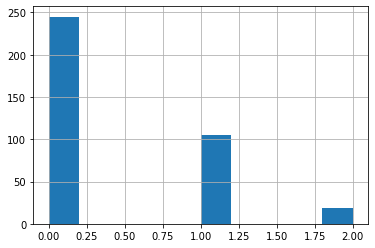

In [393]:
cpts.notna().sum(axis=1).hist()

<AxesSubplot:>

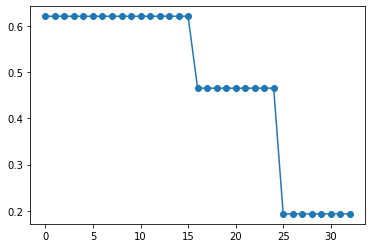

In [134]:
X_norm_pwc.iloc[6].plot(marker='o')

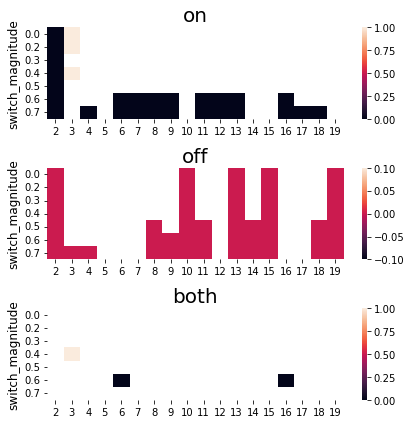

In [426]:
# sweeping magnitude; which might be equivalent to changing the pen in CPD
reload(cpa)
tosweep_key = 'switch_magnitude'
tosweep_val = [0,0.2,0.3,0.4,0.5,0.6,0.7]
kwargs = dict(low_thresh=1,high_thresh=0)
doplots = True
min_size=2
cdf_d_d,sig_d_d,fig,axs = cpa.sweep_test_switch_ratio(X_norm_pwc.iloc[:,min_size:(-(min_size-1))],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)


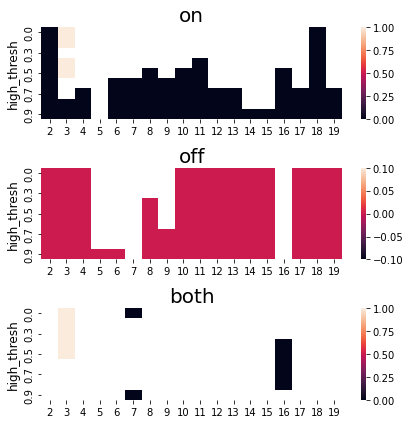

In [395]:
# sweeping high_thresh; 
reload(cpa)
tosweep_key = 'high_thresh'
tosweep_val = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
kwargs = dict(low_thresh=0.1,high_thresh=0,switch_magnitude=0)
doplots = True
min_size=2
cdf_d_d,sig_d_d,fig,axs = cpa.sweep_test_switch_ratio(X_norm_pwc.iloc[:,min_size:(-(min_size-1))],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)


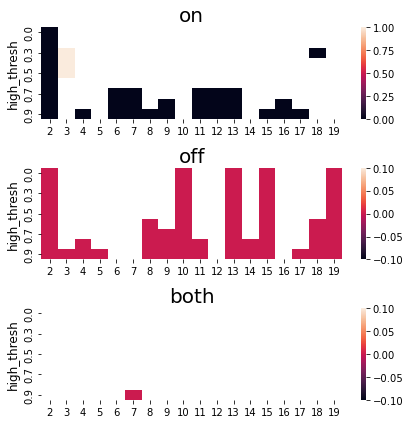

In [452]:
# sweeping high_thresh; no low thresh 
reload(cpa)
tosweep_key = 'high_thresh'
tosweep_val = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
kwargs = dict(low_thresh=1,high_thresh=0,switch_magnitude=0)
doplots = True
min_size=2
cdf_d_d,sig_d_d,fig,axs = cpa.sweep_test_switch_ratio(X_norm_pwc.iloc[:,min_size:(-(min_size-1))],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)


2


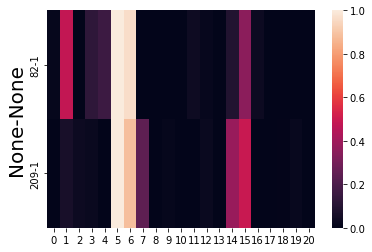

In [434]:
switch_on,switch_off,changes_df = cpa.detect_switch_pwc(X_norm_pwc,switch_magnitude=0.7,low_thresh=1,high_thresh=0)

X_norm = X / X.max(axis=1).values[:,None]
tt=5
sns.heatmap(X_norm.loc[switch_on[tt]])
print(X_norm.loc[switch_on[tt]].shape[0])

In [438]:
switch_on.sum(axis=0).mean()

0.47619047619047616

In [440]:
switch_on.mean().mean()

0.0012904890953671442

In [451]:
scipy.stats.binom.ppf(0.7,switch_on.shape[0],switch_on.mean().mean())

1.0

In [436]:
switch_on.sum(axis=0)

0     0
1     0
2     2
3     1
4     0
5     2
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    2
15    1
16    0
17    0
18    0
19    1
20    0
dtype: int64

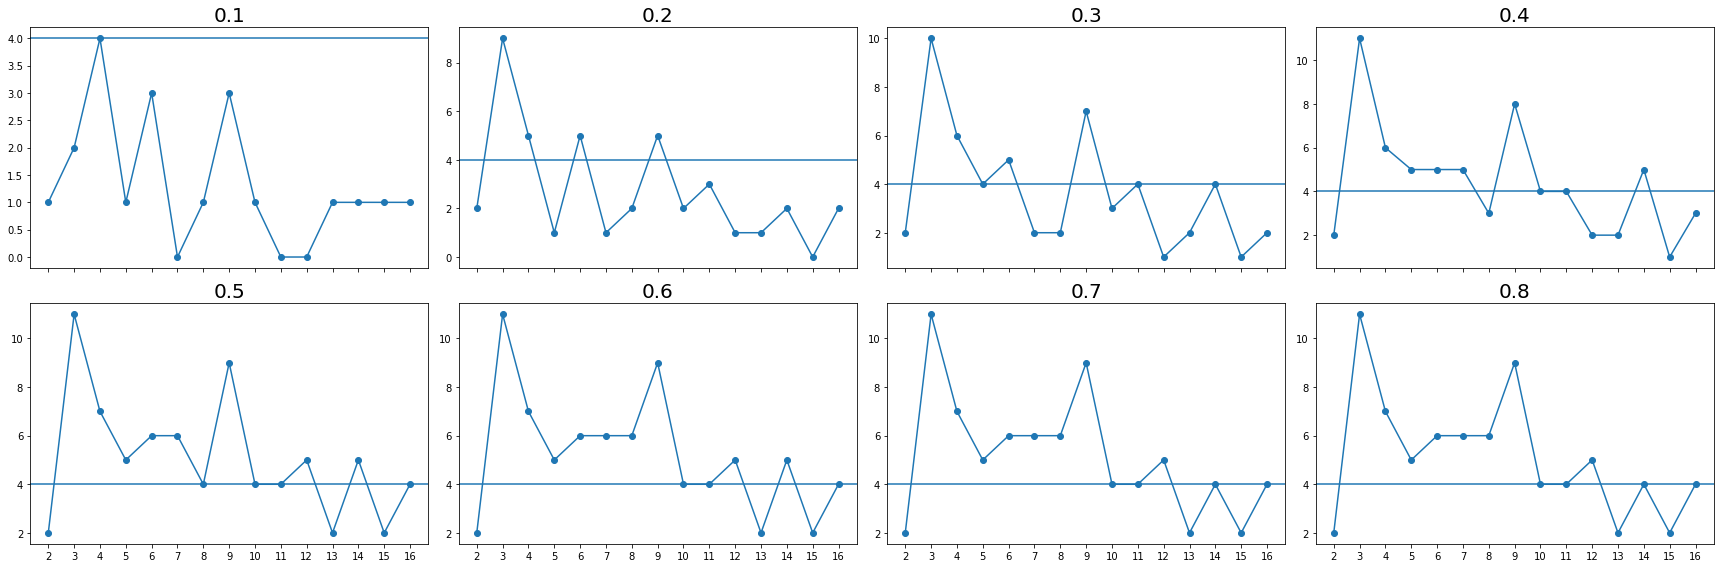

In [396]:
# first time popup
window = 5
rate_thresh_l = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
nplots = len(rate_thresh_l)
fig,axs=ph.subplots_wrapper(nplots,return_axs=True,sharex=True)
for ii,rate_thresh in enumerate(rate_thresh_l):
    ax=axs.ravel()[ii]
    popup_trial,switch_on=cpa.detect_popup(X_norm_pwc ,window=window,thresh=0.8,rate_thresh=rate_thresh)

    switch_on_popup_only=switch_on.loc[popup_trial['ispopup']]
    switch_on_popup_only=switch_on_popup_only.iloc[:,min_size:-(window-1)]
    p = switch_on_popup_only.mean().mean()
    npopups=switch_on_popup_only.sum()
    ax=npopups.plot(marker='o',xticks=npopups.index,ax=ax)

    q=1-(0.05 / npopups.shape[0])
    p = p
    sig_ct = scipy.stats.binom.ppf(q,npopups.shape[0],p=p)
    ax.axhline(sig_ct)
    ax.set_title(rate_thresh)
plt.tight_layout()



In [401]:
X_norm = X / X.max(axis=1).values[:,None]

<AxesSubplot:ylabel='None-None'>

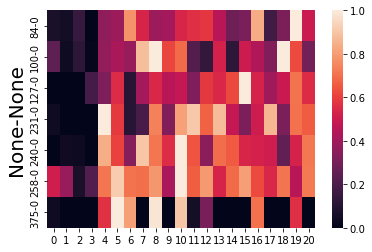

In [403]:
popup_trial,switch_on=cpa.detect_popup(X_norm_pwc ,window=window,thresh=0.8,rate_thresh=0.6)
sns.heatmap(X_norm.loc[switch_on[4]])

In [404]:
switch_on_d = {}

popup_trial,switch_on_d['popup_pwc']=cpa.detect_popup(X_norm_pwc ,window=window,thresh=0.8,rate_thresh=0.6)
switch_on_d['change_pwc'],switch_off,changes_df = cpa.detect_switch_pwc(X_norm_pwc,switch_magnitude=0.3,low_thresh=1,high_thresh=0)
switch_on_d['change'],switch_off,changes_df = cpa.detect_switch_by_change(X,thresh_ratio_low=0.1,thresh_ratio_high=0.5,sustain_on=1)
switch_on_d['change_sustain'],switch_off,changes_df = cpa.detect_switch_by_change(X,thresh_ratio_low=0.1,thresh_ratio_high=0.5,sustain_on=4)



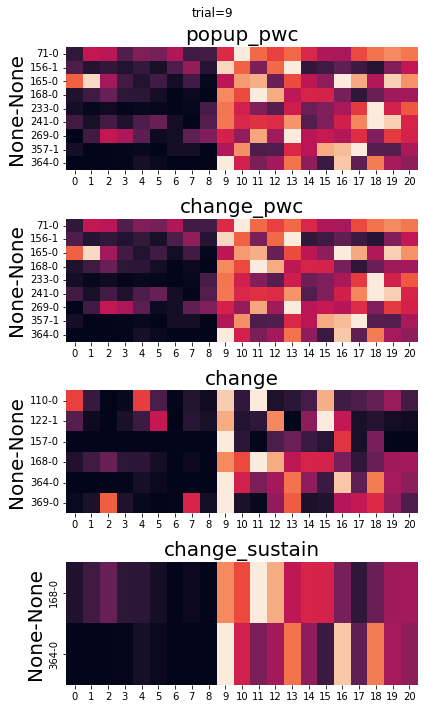

In [425]:
nplots = len(switch_on_d)
tt= 9
fig,axs=plt.subplots(nplots,1,figsize=(6,10))
fig.suptitle(f'trial={tt}')
for ii,(k, swo) in enumerate(switch_on_d.items()):
    ax=axs.ravel()[ii]
    sns.heatmap(X_norm.loc[swo[tt]],ax=ax,cbar=False)
    ax.set_title(k)
plt.tight_layout()